<h1> Feature engineering <br>
Modelling <br>
and Evaluation</h2>
<br>
<br>
<b> This is work in progress! </b> <p> We need to add the deterministic process to the training data. We need to find out how to implement lagged variables, we need to discuss whether,we should use future values as well. 

<ol>
<li>Deterministic process</li>
<li>Lagged variables</li>
<li> Fourier</li>
<li>Seasonal indicators (very important)</li>
<li></li>
<li></li>
<li></li>
</ol>

<h1> 1. Getting started </h1>
<h2> 1.1 Importing libraries </h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer



import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers, Input, callbacks
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation

from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import  CalendarFourier

<h2> 1.2 Downloading data </h2>

In [2]:
df = pd.read_csv('Preprocessed_data.csv')
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop(['Date'], axis=1, inplace=True)

<h2> 1.3 Splitting data in 3*2

In [202]:
y = df['Salmon_exp_vol']
X = df.loc[:,'FX_EURONOK':]

X_train, X_eval, y_train, y_eval = train_test_split(X,y, 
                                                    test_size=0.2,
                                                    shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_eval, y_eval, 
                                                test_size=0.5,
                                                shuffle=False)

In [203]:
def seasonal_indicators(X):
    weeks = [1,2,3,4, 49,50,51,52]
    indicator_df = pd.DataFrame()
    for ind_week in range(len(weeks)):
        column = np.where(X.index.isocalendar().week==weeks[ind_week],1,0)
        indicator_df['IndWeek'+str(weeks[ind_week])] = column
    indicator_df.index = X.index
    new_X = pd.concat([X, indicator_df],axis=1)
    return new_X
indicator_func = FunctionTransformer(func=seasonal_indicators)


<h1> 2. Feature engineering </h1>

<h2> 2.1 Manual imputing </h2>

In [204]:
X_train['FX_EURONOK']['2002-10-14'] = 7.34
X_train['FX_EURONOK']['2008-08-04'] = 7.9995
X_train['FX_EURONOK']['2008-08-08'] = 7.9915
X_train['FX_EURONOK']['2008-08-11'] = 7.9975
X_train['FX_EURONOK']['2008-08-18'] = 7.9740

<h2> 2.2 Time dummy and Fourier  </h2>

In [274]:
def det_process(X, startValue=None):
    fourier0  =  CalendarFourier(freq='A',  order=3)
    fourier1  =  CalendarFourier(freq='6M',  order=3)
    fourier2  =  CalendarFourier(freq='Q',  order=3)

    dp = DeterministicProcess(
        index=X.index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier0,fourier1,fourier2],
        drop=True
    ) 
    dp = dp.in_sample()
    dp['trend'] += startValue
    new_X = pd.concat([X,dp], axis=1)
    return new_X
time_func = FunctionTransformer(func=det_process, 
                                kw_args={'startValue':None})


<h2> 2.3  Column specific engineering </h2>
<h3> 2.3.1 Log transformation </h3>

In [209]:
def log_transformation(X):
    X = np.log1p(X)
    X = pd.DataFrame(X)
    return X
log_func = FunctionTransformer(func=log_transformation)

<h3> 2.3.2 Lagging variables

In [210]:
def lagged_func_org(X, target=None):
    X =  pd.concat([target, X], axis=1)
    lags = [[1,2,3,4],[13],[1,5],[1,2,3,4]]
    shift_cols = ['Salmon_exp_vol', 'Interest_rate', 'Food_index', 'FX_EURONOK']

    sec_it = 0
    lagged_df = pd.DataFrame()
    for n_col in range(len(shift_cols)):
        for n_lag  in range(len(lags[n_col])):
            sec_it+=1
            lagged_df[str(shift_cols[n_col]+
                      '_lag'+
                      str(lags[n_col][n_lag]))] = X[shift_cols[n_col]].shift(lags[n_col][n_lag])
    ldf = pd.concat([X,lagged_df],axis=1).dropna()
    return ldf

lagged_func = FunctionTransformer(func=lagged_func_org, 
                                  kw_args={'target':None})

<h2> 2.4  Z-scoring </h2>

In [211]:
zScore_func = StandardScaler()
zScoreTarget_func = StandardScaler()

<h2> 2.5 Reshaping 2d->3d array

In [212]:
def reshaper(X):
    X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])    
    return   X_reshaped
reshape_func = FunctionTransformer(func=reshaper)


<h1> 3. LSTM model </h1>

In [295]:
model = keras.Sequential([
    layers.LSTM(50, input_shape=(1,94)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='LeakyReLU'),
    layers.Dense(1)
])
model.compile(optimizer='adam',
              loss='mae')

early_stopping = callbacks.EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

<h1> 4.  Pipelining </h1>
<h2> 4.1 Column specific pipeline </h2>

In [290]:
engineering_func = ColumnTransformer(
    transformers=[
        ('loger', log_func, ['FX_EURONOK']),
    ], remainder='passthrough')

<h2> 4.2 Total pipeline </h2>

In [215]:
# zScore_func = StandardScaler()
# zScoreTarget_func = StandardScaler()

# engineering_func = ColumnTransformer(
#     transformers=[
#         ('loger', loger, log_cols),
#         ('target_Z', zScoreTarget_func, 'Salmon_exp_vol'),
#     ], remainder='passthrough')

# pipe = Pipeline(steps=[
#     ('Col_spec', engineering_func)
# ])


# X_train_preprocessed = pipe.fit_transform(X_train, y_train)

In [296]:
pipe = Pipeline(steps=[
    ('det', time_func),
    ('ind', indicator_func),
    ('lag', lagged_func),
    ('Col_spec', engineering_func),
    ('zScore_func', zScore_func),
    ('res', reshape_func)
    # ('lstm', model)
])

# X_train_preprocessed = pipe.set_params(lag__kw_args={'target':y_train}).fit_transform(X_train)
# X_val_preprocessed = pipe.set_params(lag__kw_args={'target':y_val}).transform(X_val)
# X_test_preprocessed = pipe.set_params(lag__kw_args={'target':y_test}).transform(X_test)

pipe.set_params(det__kw_args={'startValue':0}, lag__kw_args={'target':y_train})
X_train_preprocessed  = pipe.fit_transform(X_train)

pipe.set_params(det__kw_args={'startValue':960}, lag__kw_args={'target':y_val})
X_val_preprocessed  = pipe.fit_transform(X_val)

pipe.set_params(det__kw_args={'startValue':1080}, lag__kw_args={'target':y_test})
X_test_preprocessed  = pipe.fit_transform(X_test)

# X_train_preprocessed = pipe.set_params(lag__kw_args={'target':y_train}).fit_transform(X_train)
# X_val_preprocessed = pipe.set_params(lag__kw_args={'target':y_val}).transform(X_val)
# X_test_preprocessed = pipe.set_params(lag__kw_args={'target':y_test}).transform(X_test)
pipe

Pipeline(steps=[('det',
                 FunctionTransformer(func=<function det_process at 0x000001589FF1A0D0>,
                                     kw_args={'startValue': 1080})),
                ('ind',
                 FunctionTransformer(func=<function seasonal_indicators at 0x000001589CB208B0>)),
                ('lag',
                 FunctionTransformer(func=<function lagged_func_org at 0x00000158951B89D0>,
                                     kw_args={'target': Date
2021-09-13    25827
2021-09-20    26728
2021-09-27    26410
2...
2023-12-18    18480
2023-12-25    10440
Name: Salmon_exp_vol, Length: 120, dtype: int64})),
                ('Col_spec',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('loger',
                                                  FunctionTransformer(func=<function log_transformation at 0x00000158951B8820>),
                                                  ['FX_EURONOK'])])),
                ('zScore_func', StandardScaler()),
                ('res',
                 FunctionTransformer(func=<function reshaper at 0x000001589EDC3040>))])

<h1> X. Rest are drafts.. </h1>

In [287]:
# X_test_preprocessed

In [284]:
y_train_pre = y_train[13:]
y_val_pre = y_val[13:]
y_test_pre = y_test[13:]

In [297]:
model.fit(X_train_preprocessed,y_train_pre,
          epochs=500, batch_size=25,
          validation_data=[X_val_preprocessed, y_val_pre],
          callbacks=early_stopping)


train_pred = model.predict(X_train_preprocessed)
val_pred = model.predict(X_val_preprocessed)
test_pred = model.predict(X_test_preprocessed)

Epoch 1/500
38/38 [==============================] - 3s 24ms/step - loss: 11700.2822 - val_loss: 18556.9980
Epoch 2/500
38/38 [==============================] - 0s 8ms/step - loss: 11699.4443 - val_loss: 18556.7188
Epoch 3/500
38/38 [==============================] - 0s 5ms/step - loss: 11698.3916 - val_loss: 18556.2500
Epoch 4/500
38/38 [==============================] - 0s 3ms/step - loss: 11696.7549 - val_loss: 18555.3145
Epoch 5/500
38/38 [==============================] - 0s 4ms/step - loss: 11694.0088 - val_loss: 18553.1348
Epoch 6/500
38/38 [==============================] - 0s 4ms/step - loss: 11688.6211 - val_loss: 18548.0820
Epoch 7/500
38/38 [==============================] - 0s 4ms/step - loss: 11678.7871 - val_loss: 18538.2070
Epoch 8/500
38/38 [==============================] - 0s 3ms/step - loss: 11663.1484 - val_loss: 18518.9805
Epoch 9/500
38/38 [==============================] - 0s 4ms/step - loss: 11638.8447 - val_loss: 18486.7285
Epoch 10/500
38/38 [================

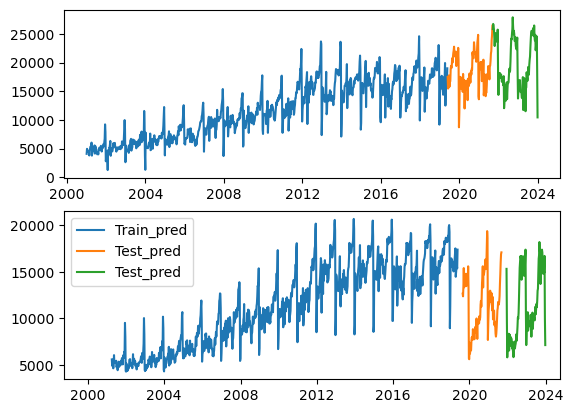

In [298]:
fig,ax = plt.subplots(2)
ax[0].plot(y_train, label='Train')
ax[0].plot(y_val, label='Valid')
ax[0].plot(y_test, label='Test')

ax[1].plot(X_train.index[13:], train_pred, label='Train_pred')
ax[1].set_xlim(10500,20000)
ax[1].plot(X_val.index[13:], val_pred, label='Test_pred')
ax[1].plot(X_test.index[13:], test_pred, label='Test_pred')

plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE


In [299]:
MAPE(train_pred, y_train_pre)

0.05853069270705594

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)